In [10]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
x_meta = pd.read_csv("../DATA/TNBC/Wu_EMBO_metadata.csv", skiprows= lambda t: t in [1])

In [3]:
'''
cell_types = ['B_cell','CD4_helper','CD14','CD34','CD56_NK','CD8_cytotoxic','CD4_CD45RO_memory','CD8_CD45RA_naive','CD4_CD45RA_naive','CD4_CD25_regulatory']
x_meta.celltype_final.unique()
array(['iCAFs', 'myCAFs', 'Plasma_Cells', 'Epithelial_Basal',
       'Endothelial', 'Myeloid', 'T_cells_unassigned', 'CD8+ T-cells',
       'NKT cells', 'NK cells', 'T-cells Cycling', 'CD4+ T-cells',
       'T-Regs', 'Tfh cells', 'dPVL', 'imPVL', 'B_Cells', 'Myoepithelial',
       'Epithelial_Basal_Cycling', 'Epithelial_Luminal_Mature'],
      dtype=object)
'''
x_meta.loc[x_meta.celltype_final == 'iCAFs', 'celltype_final'] = 'CAF'
x_meta.loc[x_meta.celltype_final == 'myCAFs', 'celltype_final'] = 'CAF'
x_meta.loc[x_meta.celltype_final == 'Plasma_Cells', 'celltype_final'] = 'B_cell'
x_meta.loc[x_meta.celltype_final == 'Epithelial_Basal', 'celltype_final'] = 'Cancer'
x_meta.loc[x_meta.celltype_final == 'T_cells_unassigned', 'celltype_final'] = 'OMIT'
x_meta.loc[x_meta.celltype_final == 'CD8+ T-cells', 'celltype_final'] = 'CD8+_T_cell'
x_meta.loc[x_meta.celltype_final == 'NKT cells', 'celltype_final'] = 'NK_cell'
x_meta.loc[x_meta.celltype_final == 'NK cells', 'celltype_final'] = 'NK_cell'
x_meta.loc[x_meta.celltype_final == 'T-cells Cycling', 'celltype_final'] = 'OMIT'
x_meta.loc[x_meta.celltype_final == 'CD4+ T-cells', 'celltype_final'] = 'CD4+_T_cell'
x_meta.loc[x_meta.celltype_final == 'T-Regs', 'celltype_final'] = 'Treg'
x_meta.loc[x_meta.celltype_final == 'Tfh cells', 'celltype_final'] = 'CD4+_T_cell'
x_meta.loc[x_meta.celltype_final == 'dPVL', 'celltype_final'] = 'PVL'
x_meta.loc[x_meta.celltype_final == 'imPVL', 'celltype_final'] = 'PVL'
x_meta.loc[x_meta.celltype_final == 'B_Cells', 'celltype_final'] = 'B_cell'
x_meta.loc[x_meta.celltype_final == 'Myoepithelial', 'celltype_final'] = 'Epithelial'
x_meta.loc[x_meta.celltype_final == 'Epithelial_Basal_Cycling', 'celltype_final'] = 'Cancer'
x_meta.loc[x_meta.celltype_final == 'Epithelial_Luminal_Mature', 'celltype_final'] = 'Epithelial'

In [4]:
x_meta = x_meta.set_index('NAME')
del x_meta.index.name

In [5]:
# x_meta.to_csv('../DATA/TNBC/Wu_EMBO_metadata_v2.csv')

In [6]:
scdata = sc.read_10x_mtx("../DATA/TNBC/counts_matrix/")
scdata.obs = pd.DataFrame(scdata.obs.merge(x_meta, left_index=True, right_index=True).loc[:,['celltype_final','patientID']])
scdata.obs.columns = ['celltype', 'patientID']
scdata.obs.set_index(pd.Index([c+'_'+rn[-16:-1] for c, rn in zip(scdata.obs.celltype, scdata.obs.index)]), inplace=True)

In [43]:
data_directories = ["../DATA/b_cells_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/",
                    "../DATA/cd4_t_helper_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/",
                    "../DATA/cd14_monocytes_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/",
                    "../DATA/cd34_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/",
                    "../DATA/cd56_nk_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/",
                    "../DATA/cytotoxic_t_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/",
                    "../DATA/memory_t_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/",
                    "../DATA/naive_cytotoxic_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/",
                    "../DATA/naive_t_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/",
                    "../DATA/regulatory_t_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/"]
cell_types = ['B_cell','CD4+_T_cell','Myeloid','Myeloid','NK_cell','CD8+_T_cell','CD4+_T_cell','CD8+_T_cell','CD4+_T_cell','Treg']
bkdata_paths = ['../DATA/TCGA/TCGA_GDC_HTSeq_TPM.csv',
              '../DATA/METABRIC/METABRIC.csv',
              '../DATA/SDY67/SDY67_477.csv']# gene_list_path = '../DATA/Immune Gene Lists/genes.csv'
data_paths = ['../DATA/TCGA/TCGA_GDC_HTSeq_TPM.csv',
              '../DATA/METABRIC/METABRIC.csv',
              '../DATA/SDY67/SDY67_468.csv',
              '../DATA/Gene Lists/immport_genelist.csv',
              '../DATA/Gene Lists/scdata_genelist_filtered_v2.csv']

In [25]:
def FeatureList(paths: list) -> list:
    features = None
    for path in tqdm(paths):
        mydata = pd.read_csv(path, index_col = 0)
        if features == None:
            features = set(mydata.index.values.tolist())
        else:
            features = features.intersection(set(mydata.index.values.tolist()))
    features = list(features)
    features.sort()
    return features

In [44]:
# Select features
print('Loading datasets to select features')
features = FeatureList(data_paths)

Loading datasets to select features


In [8]:
scdata.obs.patientID.unique()

array(['P1', 'P2', 'P3', 'P4', 'P5'], dtype=object)

In [20]:
scdata = scdata[scdata.obs['celltype'] != 'OMIT']

Trying to set attribute `.var` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


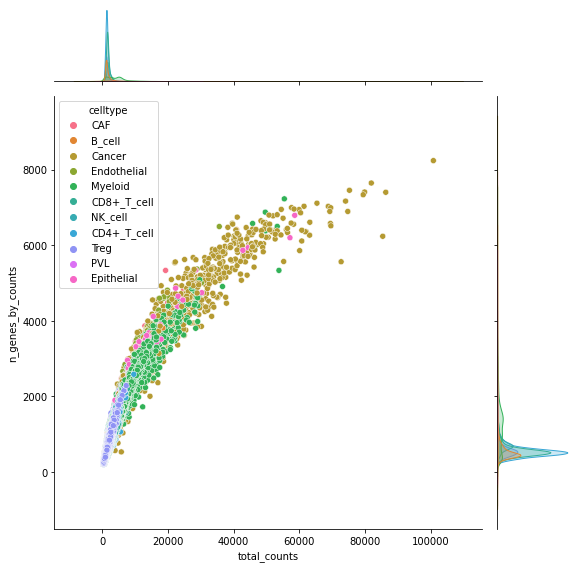

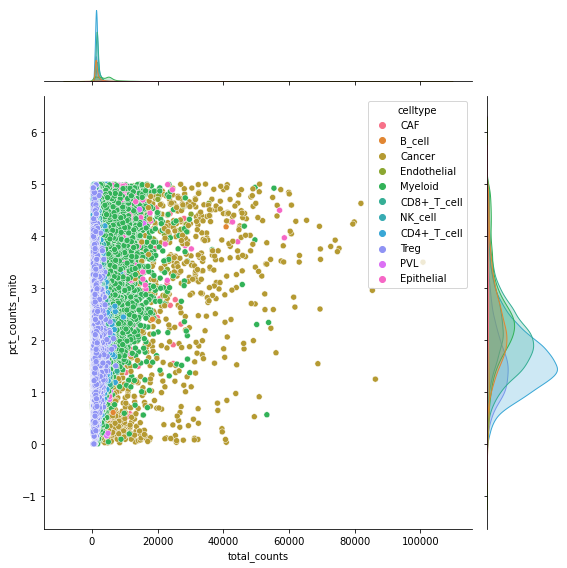

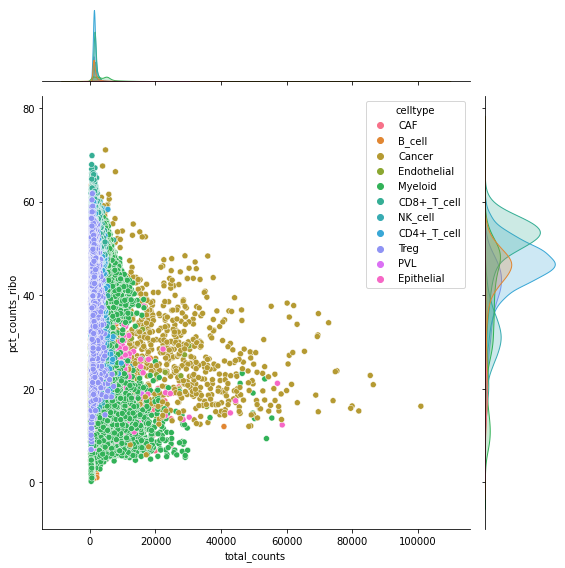

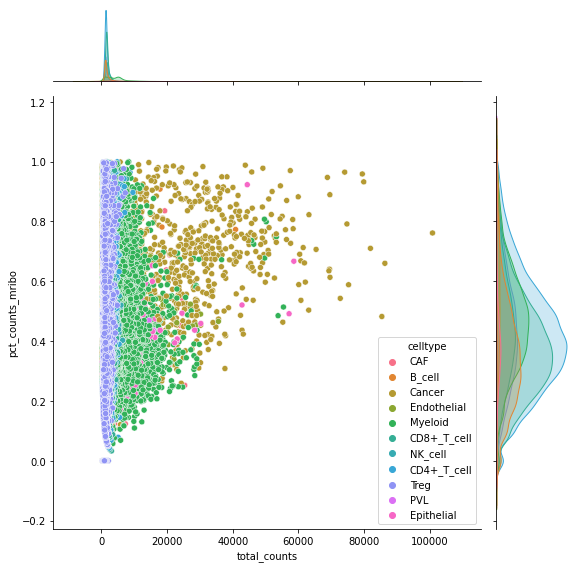

In [21]:
'''
Creates preprocessed instance of input data
scdata should be in matrix.mtx within specified folders along with barcodes.tsv and genes.tsv
bkdata should have sample names as columns and gene names as rows
gene_list should have no row or column names/index
'''
# Read and merge 10X Genomics scRNA-seq data
# scdata = None
for d, c in zip(tqdm(data_directories), cell_types):
    x = sc.read_10x_mtx(d)
    x.obs['celltype'] = [c]*len(x.obs.index)
    x.obs['patientID'] = ['P0']*len(x.obs.index)
    # Change each observation (cell) name to celltype + barcode
    x.obs.set_index(pd.Index([c+'_'+rn[:-2] for rn in x.obs.index]), inplace=True)
    if scdata is not None:
        scdata = ad.concat([scdata, x])
    else:
        scdata = x
# Filter out cells and genes
sc.pp.filter_cells(scdata, min_genes=200)
sc.pp.filter_genes(scdata, min_cells=1)
# Search for prefix "MT-" (mitochondrial genes) and make new column in variable annotations
# Search for prefix "RPL/RPS" for ribosomal genes and "MRPL/MRPS" for mitochondrial ribosomal genes
scdata.var['mito'] = scdata.var.index.str.match('^MT-')
scdata.var['ribo'] = scdata.var.index.str.startswith(('RPL','RPS'))
scdata.var['mribo'] = scdata.var.index.str.startswith(('MRPL','MRPS'))
# Calculate QC metrics as per McCarthy et al., 2017 (Scater)
sc.pp.calculate_qc_metrics(scdata, qc_vars=['mito','ribo', 'mribo'], inplace=True)
# Plot QC metrics
sns.jointplot(x='total_counts', y='n_genes_by_counts', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
sns.jointplot(x='total_counts', y='pct_counts_mito', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
sns.jointplot(x='total_counts', y='pct_counts_ribo', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
sns.jointplot(x='total_counts', y='pct_counts_mribo', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
plt.show()


In [ ]:
# [scdata.obs.index[i] for i in range(len(scdata.obs.index)) if scdata.obs.index.duplicated(keep=False)[i] == True] # takes a long time to run for some reason
# scdata.obs.index.equals("CAF_CATGCCTTCGCGATC")

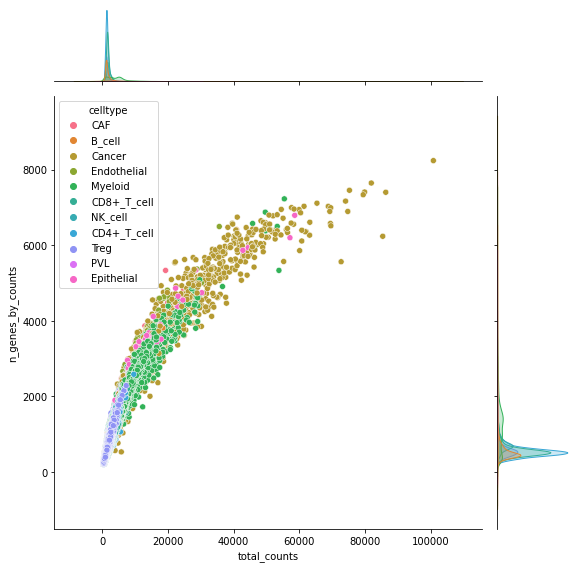

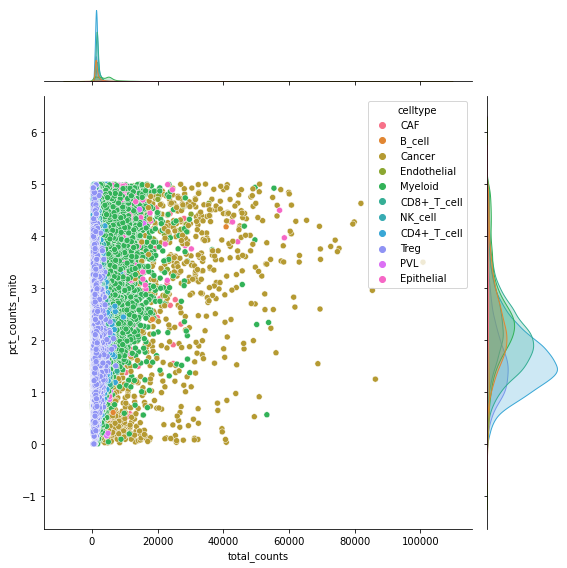

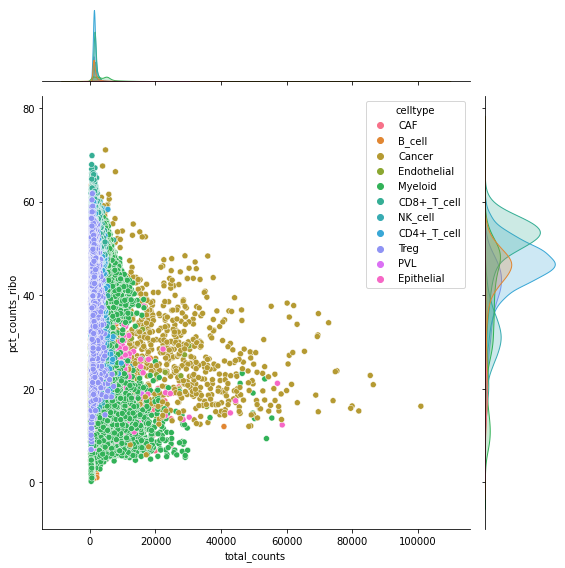

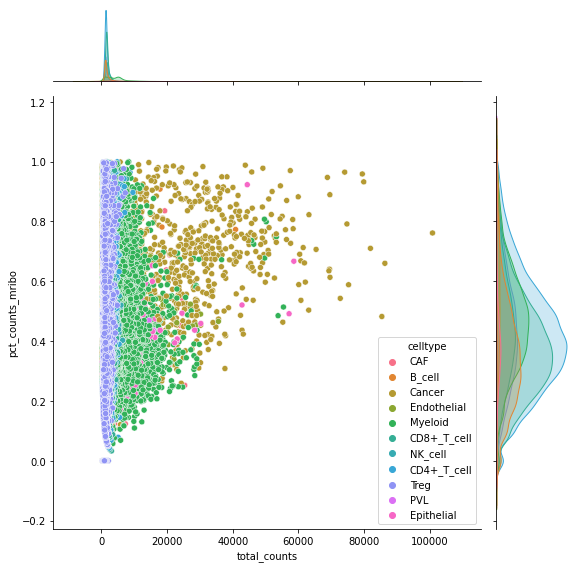

In [22]:
# Filter out cells with >5% of counts from mitochondria and mitoribosome
# scdata = scdata[scdata.obs.pct_counts_ribo > 30, :]
scdata = scdata[scdata.obs.pct_counts_mito < 5, :]
scdata = scdata[scdata.obs.pct_counts_mribo < 1, :]

# Plot QC metrics
sns.jointplot(x='total_counts', y='n_genes_by_counts', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
sns.jointplot(x='total_counts', y='pct_counts_mito', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
sns.jointplot(x='total_counts', y='pct_counts_ribo', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
sns.jointplot(x='total_counts', y='pct_counts_mribo', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
plt.show()

In [28]:
scdata

View of AnnData object with n_obs × n_vars = 104905 × 3000
    obs: 'celltype', 'patientID', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_mribo', 'log1p_total_counts_mribo', 'pct_counts_mribo'
    var: 'n_cells', 'mito', 'ribo', 'mribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [45]:
scdata = scdata[:,scdata.var_names.isin(features)]

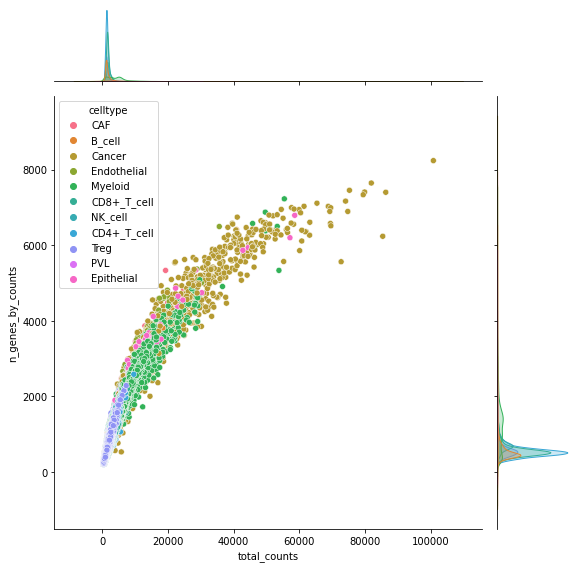

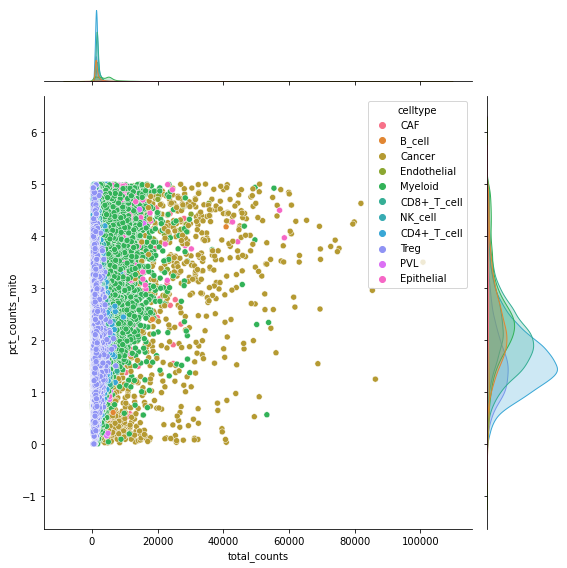

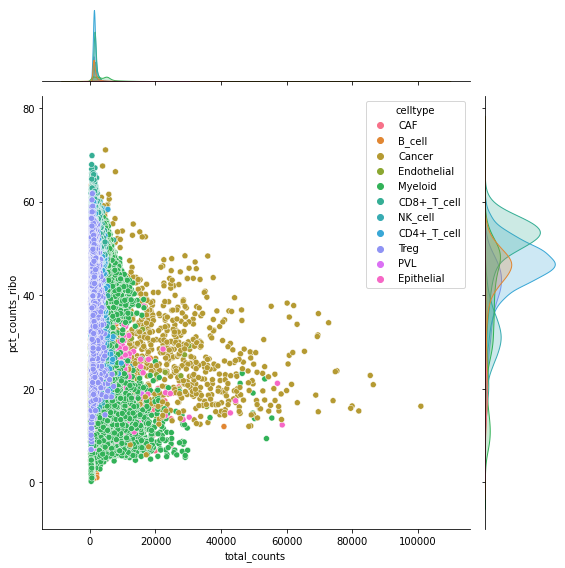

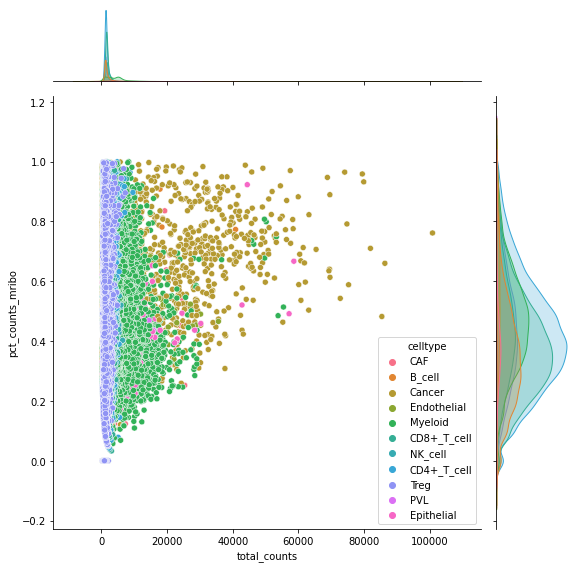

In [46]:
# Plot QC metrics
sns.jointplot(x='total_counts', y='n_genes_by_counts', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
sns.jointplot(x='total_counts', y='pct_counts_mito', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
sns.jointplot(x='total_counts', y='pct_counts_ribo', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
sns.jointplot(x='total_counts', y='pct_counts_mribo', height=8, data=scdata.obs,
    kind='scatter', hue='celltype')
plt.show()

In [47]:
# Load bulk RNA-seq dataset (TCGA-BRCA)
bkdata = []
for d in tqdm(bkdata_paths):
    print(f'Loading bulk dataset: {d}')
    x = pd.read_csv(d, index_col=0)
    x = x.dropna(axis=1)
    print('Processing bulk dataset')
    # Transpose, filter out genes not in gene list, then sort column (by gene name)
    x = x.T
    x = x.loc[:,x.columns.isin(features)].sort_index(axis=1)
#     x = x.values.astype(float)
#     x = MinMaxNorm(tf.math.log1p(x))
    bkdata.append(x)
    
# bkdata = tf.concat(bkdata, axis=0)

Loading bulk dataset: ../DATA/TCGA/TCGA_GDC_HTSeq_TPM.csv
Processing bulk dataset
Loading bulk dataset: ../DATA/METABRIC/METABRIC.csv
Processing bulk dataset
Loading bulk dataset: ../DATA/SDY67/SDY67_477.csv
Processing bulk dataset



In [48]:
bkdata[1].shape

(1894, 3000)

In [67]:
bkdata[2].quantile([0.1,0.5,0.75])

,A2M,AACS,AANAT,AATK,ABCA1,ABCA5,ABCA7,ABCB9,ABCC4,ABCC5,...,ZFYVE9,ZMAT3,ZNF148,ZNF219,ZNF3,ZNF443,ZNF675,ZNF738,ZWILCH,ZYX
0.10,100.0,678.6,29.0,343.0,860.6,626.6,4607.2,96.0,924.2,1686.2,...,262.6,2629.2,4816.6,372.6,1162.4,62.0,781.8,256.6,427.6,22028.0
0.50,236.0,1552.0,63.0,922.0,2236.0,1062.0,9830.0,219.0,1913.0,3532.0,...,512.0,5592.0,10344.0,1024.0,2228.0,115.0,1421.0,482.0,822.0,61704.0
0.75,365.0,1744.0,83.0,1229.0,3469.0,1406.0,12778.0,282.0,2219.0,4088.0,...,735.0,6818.0,12206.0,1232.0,2568.0,146.0,1740.0,593.0,997.0,74429.0


In [206]:
data = bkdata[2].describe()

In [ ]:
sns.catplot(data = data.T.reset_index().melt(id_vars=['index'], value_vars=['mean','std','min','25%','50%','75%','max']), hue='variable', x='index', y='value')

In [256]:
import matplotlib.ticker as ticker

In [268]:
tmp = data.iloc[0:100,:].T.reset_index().melt(id_vars=['index'], value_vars=['min','mean','max'])

['A2M',
 'AHCTF1',
 'APOC1',
 'BBC3',
 'BST2',
 'CBFA2T3',
 'CD3D',
 'CEACAM19',
 'CLTCL1',
 'CSNK2B',
 'DAPK1',
 'DOCK6',
 'EPCAM',
 'FBLIM1',
 'FOXO1',
 'GP1BA',
 'HLA-DOB',
 'IFIH1',
 'IL19',
 'ITGA3',
 'KLLN',
 'LPCAT2',
 'MAP3K11',
 'MMD',
 'NECAP2',
 'NPHP4',
 'PCDH11Y',
 'PITX1',
 'PPP1R13B',
 'PSMB5',
 'RAB11A',
 'RHD',
 'SACS',
 'SH3GLB1',
 'SMURF2',
 'STEAP3',
 'TGFBR2',
 'TNFRSF8',
 'TRPV6',
 'VSIG10']

In [285]:
bkdata[0].shape

(1102, 3000)

KeyboardInterrupt: 

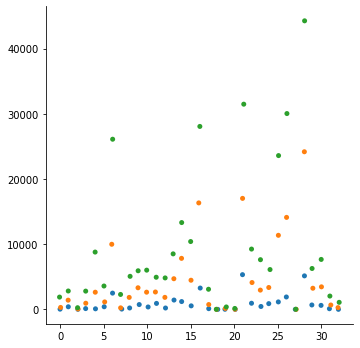

In [284]:
g = sns.catplot(data = tmp, hue='variable', x='index', y='value')
plt.xticks(tmp['index'].unique()[::75].tolist(),
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'  
)
# for ax in g.axes.flat:
#     ax.xaxis.set_major_locator(ticker.LinearLocator(40))
plt.show()

In [222]:
data.loc[['mean','min','max']]

,A2M,AACS,AANAT,AATK,ABCA1,ABCA5,ABCA7,ABCB9,ABCC4,ABCC5,...,ZFYVE9,ZMAT3,ZNF148,ZNF219,ZNF3,ZNF443,ZNF675,ZNF738,ZWILCH,ZYX
mean,297.002096,1412.199161,67.113208,941.052411,2633.51782,1143.731656,9986.809224,231.991614,1836.467505,3313.721174,...,569.035639,5365.09434,9734.431866,957.809224,2099.410901,117.501048,1423.42348,489.06499,812.419287,57335.880503
min,33.000000,398.000000,13.000000,121.000000,87.00000,402.000000,2494.000000,46.000000,215.000000,738.000000,...,68.000000,1074.00000,1365.000000,263.000000,708.000000,22.000000,447.00000,118.00000,201.000000,9358.000000
max,1885.000000,2819.000000,255.000000,2800.000000,8790.00000,3583.000000,26101.000000,2289.000000,5068.000000,5921.000000,...,1645.000000,9711.00000,18189.000000,1918.000000,3889.000000,269.000000,2992.00000,1262.00000,1729.000000,135098.000000


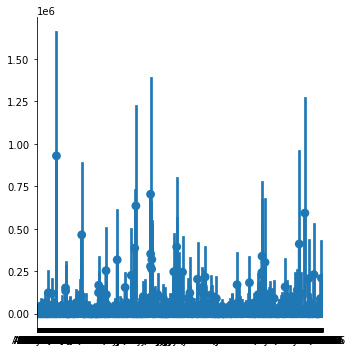

In [223]:
sns.catplot(data = data.loc[['mean','min','max']], kind='point')

In [203]:
sns.catplot(data=bkdata[2].describe()[0,:], kind='point')

TypeError: '(0, slice(None, None, None))' is an invalid key

In [77]:
pd.concat([bkdata[2].agg(['mean', 'max', 'min','var']),bkdata[2].quantile([0.1,0.25,0.5,0.75,0.9])])

,A2M,AACS,AANAT,AATK,ABCA1,ABCA5,ABCA7,ABCB9,ABCC4,ABCC5,...,ZFYVE9,ZMAT3,ZNF148,ZNF219,ZNF3,ZNF443,ZNF675,ZNF738,ZWILCH,ZYX
mean,297.002096,1412.199161,67.113208,941.052411,2.633518e+03,1143.731656,9.986809e+03,231.991614,1836.467505,3.313721e+03,...,569.035639,5.365094e+03,9.734432e+03,957.809224,2099.410901,117.501048,1423.423480,489.064990,812.419287,5.733588e+04
max,1885.000000,2819.000000,255.000000,2800.000000,8.790000e+03,3583.000000,2.610100e+04,2289.000000,5068.000000,5.921000e+03,...,1645.000000,9.711000e+03,1.818900e+04,1918.000000,3889.000000,269.000000,2992.000000,1262.000000,1729.000000,1.350980e+05
min,33.000000,398.000000,13.000000,121.000000,8.700000e+01,402.000000,2.494000e+03,46.000000,215.000000,7.380000e+02,...,68.000000,1.074000e+03,1.365000e+03,263.000000,708.000000,22.000000,447.000000,118.000000,201.000000,9.358000e+03
var,54204.535710,227353.521176,1172.142619,247597.058172,2.713632e+06,220845.091706,1.710652e+07,22569.462114,453117.270475,1.278335e+06,...,83319.299147,3.840648e+06,1.173734e+07,148136.083276,375061.994671,2106.187499,231944.391716,34301.069297,71609.844837,6.019730e+08
0.1,100.000000,678.600000,29.000000,343.000000,8.606000e+02,626.600000,4.607200e+03,96.000000,924.200000,1.686200e+03,...,262.600000,2.629200e+03,4.816600e+03,372.600000,1162.400000,62.000000,781.800000,256.600000,427.600000,2.202800e+04
0.25,154.000000,1028.000000,43.000000,512.000000,1.385000e+03,804.000000,6.577000e+03,149.000000,1318.000000,2.273000e+03,...,338.000000,3.745000e+03,6.580000e+03,589.000000,1589.000000,82.000000,1064.000000,355.000000,597.000000,3.343700e+04
0.5,236.000000,1552.000000,63.000000,922.000000,2.236000e+03,1062.000000,9.830000e+03,219.000000,1913.000000,3.532000e+03,...,512.000000,5.592000e+03,1.034400e+04,1024.000000,2228.000000,115.000000,1421.000000,482.000000,822.000000,6.170400e+04
0.75,365.000000,1744.000000,83.000000,1229.000000,3.469000e+03,1406.000000,1.277800e+04,282.000000,2219.000000,4.088000e+03,...,735.000000,6.818000e+03,1.220600e+04,1232.000000,2568.000000,146.000000,1740.000000,593.000000,997.000000,7.442900e+04
0.9,548.400000,1945.000000,109.000000,1627.200000,5.138400e+03,1708.800000,1.537820e+04,362.400000,2592.200000,4.664200e+03,...,998.000000,7.897600e+03,1.410380e+04,1406.400000,2781.400000,179.400000,2030.200000,734.800000,1160.800000,8.495760e+04


In [80]:
bkdata[2].describe().T['mean']

A2M           297.002096
AACS         1412.199161
AANAT          67.113208
AATK          941.052411
ABCA1        2633.517820
ABCA5        1143.731656
ABCA7        9986.809224
ABCB9         231.991614
ABCC4        1836.467505
ABCC5        3313.721174
ABCD2        2638.312369
ABCD4        2666.039832
ABCG1        1842.230608
ABHD16A      4701.266247
ABL1         7826.553459
ABL2         4469.735849
ABR         16331.425577
ACE           741.031447
ACE2            0.893082
ACER2         146.867925
ACHE           18.561845
ACIN1       17026.165618
ACOX1        4117.259958
ACP5         2956.006289
ACSF3        3354.763103
ACSL4       11360.859539
ACTN1       14109.981132
ACTN2           3.647799
ACTN4       24176.683438
ACVR1        3242.381551
               ...      
XRCC6       17809.400419
XYLT1       12726.823899
YARS         7349.392034
YKT6        10060.341719
YWHAE       11140.236897
YWHAG       10437.675052
YWHAZ       52023.542977
ZAP70       12716.501048
ZBTB16       1692.031447


In [88]:
from mpl_toolkits import mplot3d

In [243]:
mydata = pd.read_csv('../DATA/simbulk/20201105_N-1000_C-500_simbulk_data.csv')

In [251]:
mydata.columns = bkdata[1].columns[0:2924]

In [ ]:
mydata = pd.read_csv('../DATA/simbulk/210319_GAN_N100000_C500_simbulk_data.csv')

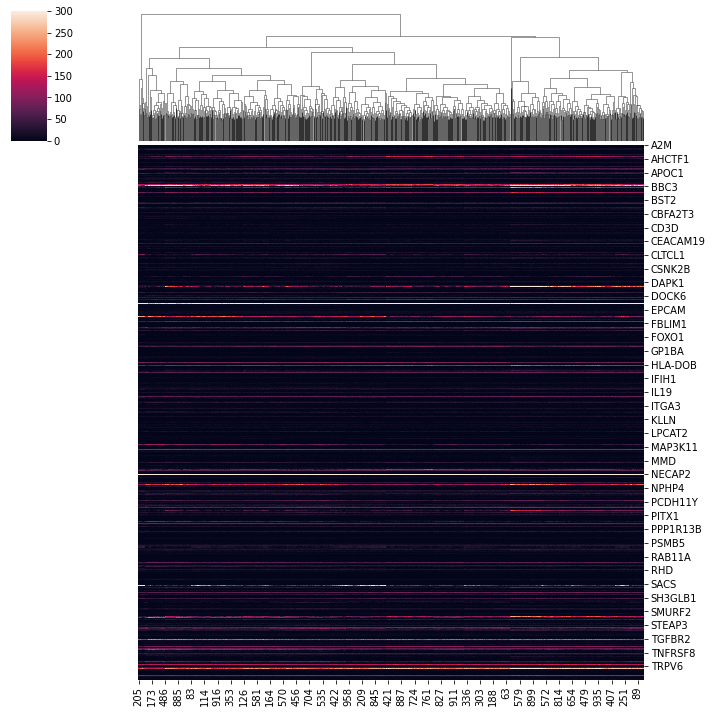

In [255]:
# mydata = bkdata[2]
# mydata.columns = [i for i in range(3000)]
# mydata.columns
# mydata = mydata.reset_index()
# mydata['index'] = [i for i in range(mydata.shape[0])]
# mydata = mydata.melt(id_vars='index')
sns.clustermap(mydata.T, row_cluster=False, vmax = 300)

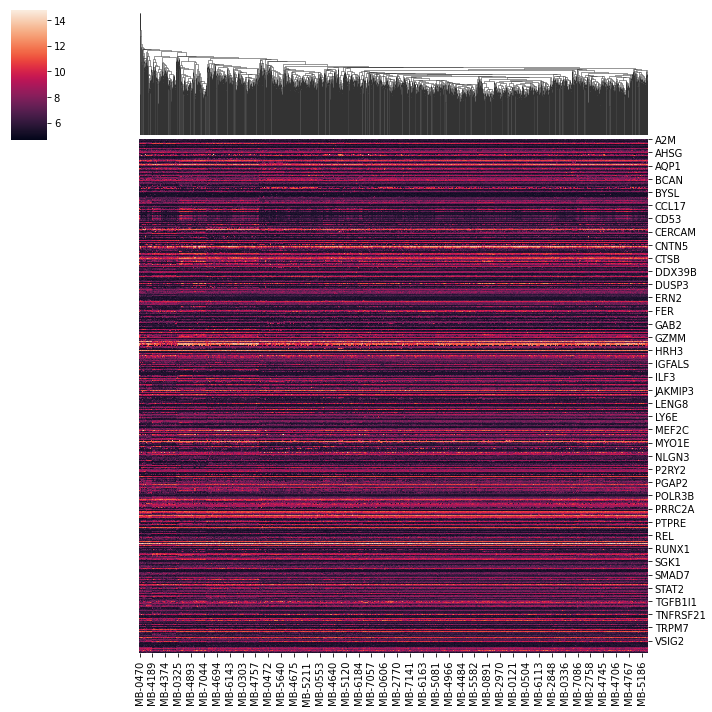

In [195]:
sns.clustermap(bkdata[1].T, row_cluster=False)

In [181]:
bkdata[0].columns = bkdata[1].columns

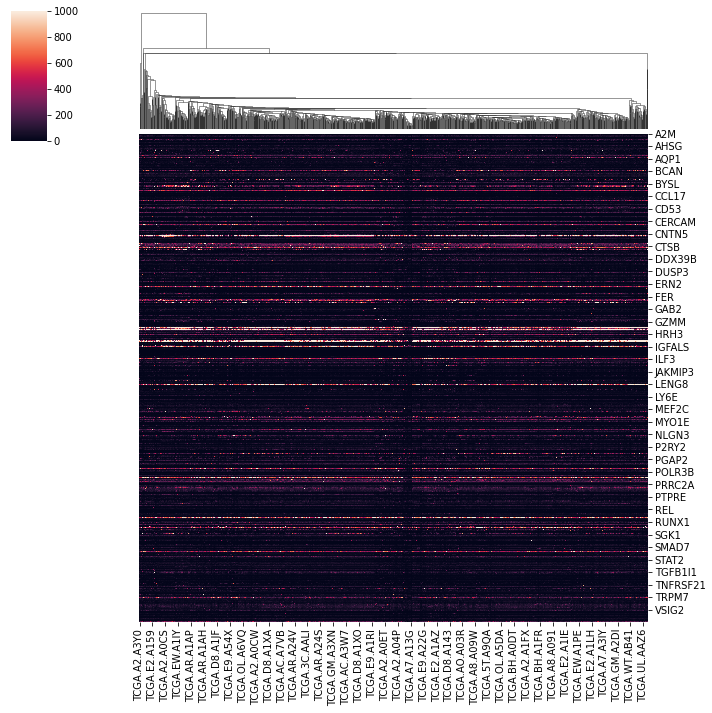

In [199]:
sns.clustermap(bkdata[0].T, row_cluster=False, vmax=1000)

Wall time: 34.9 s


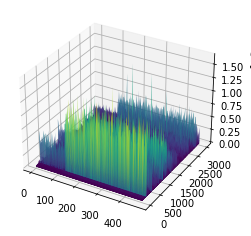

In [149]:
%%time
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(mydata['index'].values), list(mydata['variable'].values), list(mydata['value'].values), cmap='viridis')

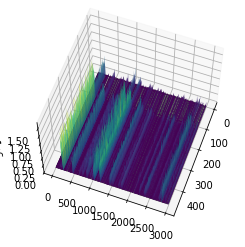

In [150]:
ax.view_init(45,20)
fig

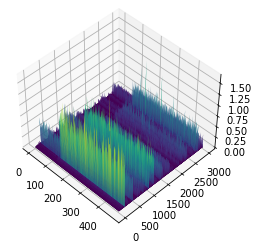

In [151]:
ax.view_init(45,315)
fig

In [ ]:
mydata = bkdata[0]
mydata.columns = [i for i in range(mydata.shape[1])]
# mydata.columns
mydata = mydata.reset_index()
mydata['index'] = [i for i in range(mydata.shape[0])]
mydata = mydata.melt(id_vars='index')
mydata

Wall time: 2min 15s


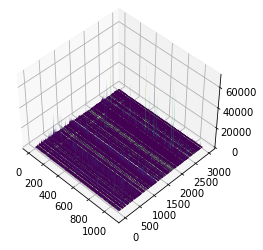

In [154]:
%%time
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(45,315)
ax.plot_trisurf(list(mydata['index'].values), list(mydata['variable'].values), list(mydata['value'].values), cmap='viridis')

In [129]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

In [131]:
X

array([[-6.        , -5.5862069 , -5.17241379, -4.75862069, -4.34482759,
        -3.93103448, -3.51724138, -3.10344828, -2.68965517, -2.27586207,
        -1.86206897, -1.44827586, -1.03448276, -0.62068966, -0.20689655,
         0.20689655,  0.62068966,  1.03448276,  1.44827586,  1.86206897,
         2.27586207,  2.68965517,  3.10344828,  3.51724138,  3.93103448,
         4.34482759,  4.75862069,  5.17241379,  5.5862069 ,  6.        ],
       [-6.        , -5.5862069 , -5.17241379, -4.75862069, -4.34482759,
        -3.93103448, -3.51724138, -3.10344828, -2.68965517, -2.27586207,
        -1.86206897, -1.44827586, -1.03448276, -0.62068966, -0.20689655,
         0.20689655,  0.62068966,  1.03448276,  1.44827586,  1.86206897,
         2.27586207,  2.68965517,  3.10344828,  3.51724138,  3.93103448,
         4.34482759,  4.75862069,  5.17241379,  5.5862069 ,  6.        ],
       [-6.        , -5.5862069 , -5.17241379, -4.75862069, -4.34482759,
        -3.93103448, -3.51724138, -3.10344828, -2

<BarContainer object of 3000 artists>

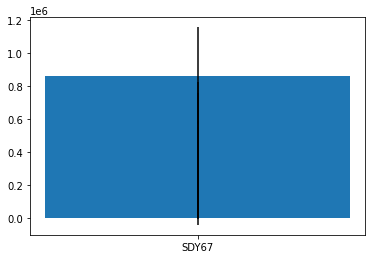

In [87]:
plt.bar(x='SDY67',height=bkdata[2].describe().T['mean'], yerr=bkdata[2].describe().T['std'])

In [ ]:
def plot_features(data):
    data = data.describe().T
    g = sns.catplot(
    data=data, kind="bar",
        x="species", y="body_mass_g", hue="sex",
        ci="sd", palette="dark", alpha=.6, height=6
    )

***

In [33]:
cell_types = scdata.obs.celltype.unique().tolist()
cell_types.remove('OMIT')

In [54]:
# Select features
print('Loading datasets to select features')
features = FeatureList(data_paths)


scdata = scdata[:,scdata.var_names.isin(features)]
sc.pp.normalize_total(scdata, target_sum=1e6) # normalize to sum to 1,000,000
# sc.pp.regress_out(scdata, ['total_counts'], n_jobs=1) # takes too long to complete


print('Dividing single cell dataset into cell types')
scdata_ = []
for c in tqdm(cell_types):
    scdata_.append(scdata[scdata.obs.celltype==c].to_df().sort_index(axis=1))
    # Add to row index 0 a cell with no gene expression (all zeros)
    # zeros = pd.DataFrame(np.zeros((1,scdata_.shape[1])), columns=scdata_.columns.values)
    # Expand into batch dimension and repeat 2-D tensor by # of samples per mini batch
    # scdata_ = tf.tile(tf.expand_dims(pd.concat([zeros,scdata_]), axis=0), [batch_size,1,1])
    # out.append(scdata_)

Loading datasets to select features


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]
c:\users\yw_ji\documents\msc thesis\code\keras\scanpy\scanpy\preprocessing\_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Dividing single cell dataset into cell types


100%|██████████| 11/11 [00:01<00:00,  8.41it/s]
